In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics

import os
os.chdir('/home/aremirata/thesis/7mw/')

from savvyworkout import lstm_preprocess
from savvyworkout import triaxial_lstm
from savvyworkout import triaxial_deepconvlstm
from savvyworkout import deeplearning_utils
from savvyworkout import visualize_lstmmodel
from sklearn.externals import joblib

from sklearn.metrics import classification_report, confusion_matrix

from IPython.core.display import display, HTML

%matplotlib inline

Using TensorFlow backend.


Loading BokehJS ...

In [2]:
os.chdir('/home/aremirata/thesis/LSTM-Human-Activity-Recognition')

# Dataset Information

The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope,3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz were captured. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used.

### Generating Data

In [3]:
# Note: Linux bash commands start with a "!" inside those "ipython notebook" cells

DATA_PATH = "data/"

!pwd && ls
os.chdir(DATA_PATH)
!pwd && ls

!python download_dataset.py

!pwd && ls
os.chdir("..")
!pwd && ls

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

/home/aremirata/thesis/LSTM-Human-Activity-Recognition
data	 LSTM_files  lstm.py	UCI Activity Recognition Factorization.ipynb
LICENSE  LSTM.ipynb  README.md
/home/aremirata/thesis/LSTM-Human-Activity-Recognition/data
download_dataset.py  __MACOSX  source.txt  UCI HAR Dataset  UCI HAR Dataset.zip

Downloading...
Dataset already downloaded. Did not download twice.

Extracting...
Dataset already extracted. Did not extract twice.

/home/aremirata/thesis/LSTM-Human-Activity-Recognition/data
download_dataset.py  __MACOSX  source.txt  UCI HAR Dataset  UCI HAR Dataset.zip
/home/aremirata/thesis/LSTM-Human-Activity-Recognition
data	 LSTM_files  lstm.py	UCI Activity Recognition Factorization.ipynb
LICENSE  LSTM.ipynb  README.md

Dataset is now located at: data/UCI HAR Dataset/


In [4]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

In [5]:
TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [6]:
X_train.shape

(7352, 128, 3)

In [7]:
y_train.shape

(7352, 1)

In [8]:
X_test.shape

(2947, 128, 3)

In [9]:
y_test.shape

(2947, 1)

In [34]:
training_data = np.linalg.norm(X_train, axis=-1)
testing_data = np.linalg.norm(X_test, axis=-1)

# Factorization On Training Data

In [35]:
from nmf_compressed.structured_nmf import structured_randomized_bppnmf
from numpy.linalg import norm, solve
from ntf_cython.nmf import nmf

In [36]:
r  = 10

### Compressed Factorization with Algo 42

In [40]:
%%time
U_algo42, V_algo42, relative_error_algo42 = structured_randomized_bppnmf(training_data, algo='algo42', q=10, r=r, max_iter = 200, eps = 0.00001, oversampling = 20, 
                     oversampling_factor = 20, random_state=2)

The matrix is dense. We use compressed block principal pivoting method
CPU times: user 38.5 s, sys: 676 ms, total: 39.2 s
Wall time: 3.28 s


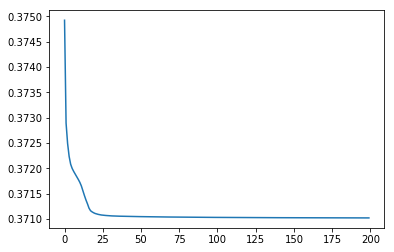

In [41]:
plt.plot(relative_error_algo42)

### COMPRESSED NMF WITH QR

In [42]:
%%time
U_qr, V_qr, relative_error_qr = structured_randomized_bppnmf(training_data, q=10, r=r, max_iter = 200, eps = 0.00001, oversampling = 20, 
                     oversampling_factor = 20, random_state=2)

The matrix is dense. We use compressed block principal pivoting method
CPU times: user 36.9 s, sys: 664 ms, total: 37.6 s
Wall time: 3.14 s


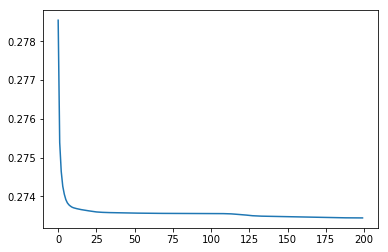

In [43]:
plt.plot(relative_error_qr)

### COMPRESSED NMF WITH ALGO 41

In [44]:
%%time
U_algo41, V_algo41, relative_error_algo41 = structured_randomized_bppnmf(training_data, algo='algo41', q=20, r=r, max_iter = 200, eps = 0.00001, oversampling = 20, 
                     oversampling_factor = 20, random_state=2)

The matrix is dense. We use compressed block principal pivoting method


ValueError: dgesv returned with info=1

#### COMPRESSED BPP WITH ALGO43

In [47]:
%%time
U_algo43, V_algo43, relative_error_algo43 = structured_randomized_bppnmf(training_data, algo='algo43', q=10, r=r, max_iter = 200, eps = 0.00001, oversampling = 20, 
                     oversampling_factor = 20, random_state=2)

The matrix is dense. We use compressed block principal pivoting method


/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ntf_cython/nmf.py:196: ConvergenceWarning: Maximum number of iteration 45 reached. Increase it to improve convergence.
  ConvergenceWarning)
/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ntf_cython/nmf.py:196: ConvergenceWarning: Maximum number of iteration 50 reached. Increase it to improve convergence.
  ConvergenceWarning)


CPU times: user 28.2 s, sys: 644 ms, total: 28.9 s
Wall time: 2.47 s


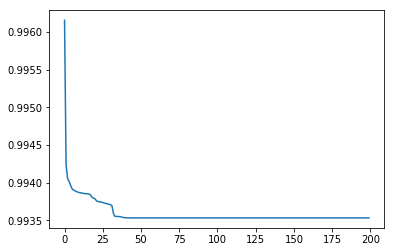

In [48]:
plt.plot(relative_error_algo43)

#### COMPRESSED BPP WITH ALGO44

In [49]:
U_algo44, V_algo44, relative_error_algo44 = structured_randomized_bppnmf(training_data, algo='algo44', q=10, r=r, max_iter = 200, eps = 0.00001, oversampling = 20, 
                     oversampling_factor = 20, random_state=2)

The matrix is dense. We use compressed block principal pivoting method


/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ntf_cython/nmf.py:196: ConvergenceWarning: Maximum number of iteration 20 reached. Increase it to improve convergence.
  ConvergenceWarning)
/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ntf_cython/nmf.py:196: ConvergenceWarning: Maximum number of iteration 25 reached. Increase it to improve convergence.
  ConvergenceWarning)
/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ntf_cython/nmf.py:196: ConvergenceWarning: Maximum number of iteration 30 reached. Increase it to improve convergence.
  ConvergenceWarning)
/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ntf_cython/nmf.py:196: ConvergenceWarning: Maximum number of iteration 35 reached. Increase it to improve convergence.
  ConvergenceWarning)
/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ntf_cython/nmf.py:196: ConvergenceWarning: Maximum number of iteration 40 reached. Increase it to improve convergence.
  

ValueError: dgesv returned with info=4

### COMPRESSED BPP WITH STRUCTURED COMPRESSION

In [50]:
%%time
U_strcom, V_strcom, relative_error_strcom = structured_randomized_bppnmf(training_data, algo='structured_compression', q=10, r=r, max_iter = 200, eps = 0.00001, oversampling = 20, 
                     oversampling_factor = 20, random_state=2)

The matrix is dense. We use compressed block principal pivoting method
CPU times: user 29 s, sys: 636 ms, total: 29.6 s
Wall time: 2.56 s


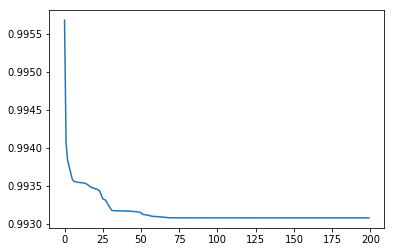

In [51]:
plt.plot(relative_error_strcom)

#### COMPRESSED BPP WITH COUNT GAUSSIAN

In [52]:
%%time
U_countgaussian, V_countgaussian, relative_error_countgaussian = structured_randomized_bppnmf(training_data, algo='count_gauss', q=10, r=r, max_iter = 200, eps = 0.00001, oversampling = 20, 
                     oversampling_factor = 20, random_state=2)

The matrix is dense. We use compressed block principal pivoting method


ValueError: Buffer dtype mismatch, expected 'double' but got 'float'

### UNCOMPRESSED BPP IMPLEMENTATION

In [53]:
%time W_uncompressed, H_uncompressed, n_iters_uncompressed, relerror_uncompressed = nmf(training_data, n_components=r, max_iter=200, random_state=2)

CPU times: user 1min 6s, sys: 1.16 s, total: 1min 7s
Wall time: 5.66 s


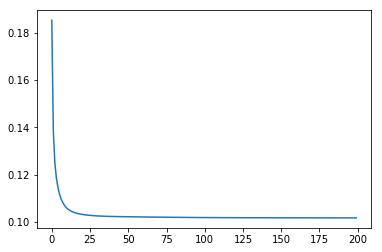

In [54]:
plt.plot(relerror_uncompressed)

# Factorization On Test Set

#### Compressed Factorization with Algo 42

In [57]:
%%time
U_algo42, V_algo42, relative_error_algo42 = structured_randomized_bppnmf(testing_data, algo='algo42', q=10, r=r, max_iter = 200, eps = 0.00001, oversampling = 20, 
                     oversampling_factor = 20, random_state=2)

The matrix is dense. We use compressed block principal pivoting method
CPU times: user 19.6 s, sys: 388 ms, total: 19.9 s
Wall time: 1.67 s


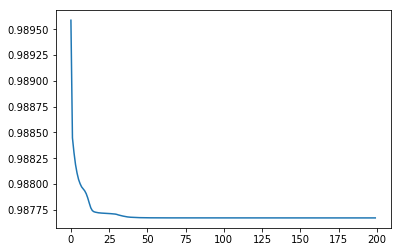

In [58]:
plt.plot(relative_error_algo42)

### Compressed Factorization with QR

In [59]:
%%time
U_qr, V_qr, relative_error_qr = structured_randomized_bppnmf(testing_data, q=10, r=r, max_iter = 200, eps = 0.00001, oversampling = 20, 
                     oversampling_factor = 20, random_state=2)

The matrix is dense. We use compressed block principal pivoting method
CPU times: user 20.3 s, sys: 496 ms, total: 20.8 s
Wall time: 1.74 s


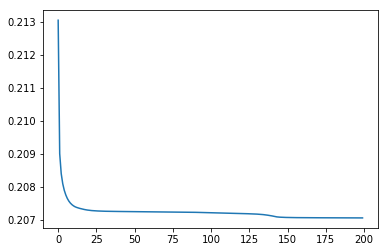

In [60]:
plt.plot(relative_error_qr)

In [61]:
%%time
U_algo41, V_algo41, relative_error_algo41 = structured_randomized_bppnmf(testing_data, algo='algo41', q=20, r=r, max_iter = 200, eps = 0.00001, oversampling = 20, 
                     oversampling_factor = 20, random_state=2)

The matrix is dense. We use compressed block principal pivoting method


/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ntf_cython/nmf.py:196: ConvergenceWarning: Maximum number of iteration 50 reached. Increase it to improve convergence.
  ConvergenceWarning)


ValueError: dgesv returned with info=2

### Compressed NMF With Algo 43

In [62]:
%%time
U_algo43, V_algo43, relative_error_algo43 = structured_randomized_bppnmf(testing_data, algo='algo43', q=10, r=r, max_iter = 200, eps = 0.00001, oversampling = 20, 
                     oversampling_factor = 20, random_state=2)

The matrix is dense. We use compressed block principal pivoting method


/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ntf_cython/nmf.py:196: ConvergenceWarning: Maximum number of iteration 45 reached. Increase it to improve convergence.
  ConvergenceWarning)
/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ntf_cython/nmf.py:196: ConvergenceWarning: Maximum number of iteration 50 reached. Increase it to improve convergence.
  ConvergenceWarning)


ValueError: dgesv returned with info=2

### COMPRESSED BPP WITH ALGO44

In [63]:
U_algo44, V_algo44, relative_error_algo44 = structured_randomized_bppnmf(testing_data, algo='algo44', q=10, r=r, max_iter = 200, eps = 0.00001, oversampling = 20, 
                     oversampling_factor = 20, random_state=2)

The matrix is dense. We use compressed block principal pivoting method


/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ntf_cython/nmf.py:196: ConvergenceWarning: Maximum number of iteration 35 reached. Increase it to improve convergence.
  ConvergenceWarning)
/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ntf_cython/nmf.py:196: ConvergenceWarning: Maximum number of iteration 40 reached. Increase it to improve convergence.
  ConvergenceWarning)
/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ntf_cython/nmf.py:196: ConvergenceWarning: Maximum number of iteration 45 reached. Increase it to improve convergence.
  ConvergenceWarning)
/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ntf_cython/nmf.py:196: ConvergenceWarning: Maximum number of iteration 50 reached. Increase it to improve convergence.
  ConvergenceWarning)


ValueError: dgesv returned with info=2

### COMPRESSED BPP WITH STRUCTURED COMPRESSION

In [64]:
%%time
U_strcom, V_strcom, relative_error_strcom = structured_randomized_bppnmf(testing_data, algo='structured_compression', q=10, r=r, max_iter = 200, eps = 0.00001, oversampling = 20, 
                     oversampling_factor = 20, random_state=2)

The matrix is dense. We use compressed block principal pivoting method
CPU times: user 13.2 s, sys: 260 ms, total: 13.4 s
Wall time: 1.13 s


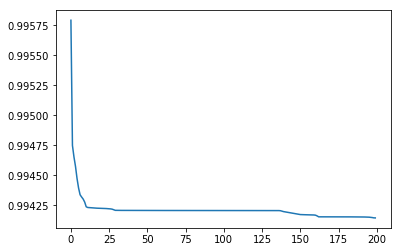

In [65]:
plt.plot(relative_error_strcom)

### COMPRESSED BPP WITH COUNT GAUSSIAN

In [66]:
%%time
U_countgaussian, V_countgaussian, relative_error_countgaussian = structured_randomized_bppnmf(testing_data, algo='count_gauss', q=10, r=r, max_iter = 200, eps = 0.00001, oversampling = 20, 
                     oversampling_factor = 20, random_state=2)

The matrix is dense. We use compressed block principal pivoting method


ValueError: Buffer dtype mismatch, expected 'double' but got 'float'

### UNCOMPRESSED BPP IMPLEMENTATION

In [67]:
%time W_uncompressed, H_uncompressed, n_iters_uncompressed, relerror_uncompressed = nmf(testing_data, n_components=r, max_iter=200, random_state=2)

CPU times: user 29.5 s, sys: 512 ms, total: 30 s
Wall time: 2.51 s


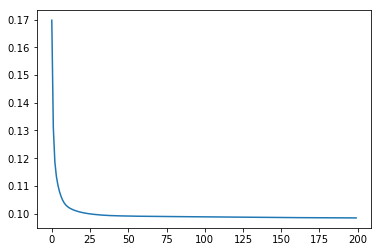

In [68]:
plt.plot(relerror_uncompressed)